# Install Dependencies

In [1]:
!pip install torch_summary

# Import Libraries

In [2]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms as T, models
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from tqdm.notebook import tqdm 

from sklearn.metrics import classification_report, recall_score, accuracy_score, f1_score, precision_score, roc_curve, auc
from sklearn.model_selection import train_test_split
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from random import shuffle, randint, choice
import numpy as np
import cv2 as cv
from glob import glob
import pandas as pd

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
!mkdir saved_model
sns.set_theme()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset

In [4]:
DIR = '../input/ocular-disease-recognition-odir5k'

full_df = pd.read_csv(f'{DIR}/full_df.csv', index_col=0)

full_df.head()

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
ID,,,,,,,,,,,,,,,,,,
0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


# Data Preprocessing

In [5]:
full_df['side'] = full_df['filename'].str[:-4].str.replace(r'\d+_', '', regex=True)

In [6]:
image_dir = '../input/ocular-disease-recognition-odir5k/ODIR-5K/'
full_df['filepath'] = full_df['filepath'].str.replace(image_dir, image_dir + 'ODIR-5K/')

In [7]:
age_intervals = [0, 20, 40, 60, 80, 100]
age_labels = ['0-20', '21-40', '41-60', '61-80', '81+']
full_df['Age Group'] = pd.cut(full_df['Patient Age'], bins=age_intervals, labels=age_labels, right=False)

In [8]:
full_df['labels_text'] = full_df['labels'].apply(lambda x: x[2])
full_df['target'] = np.where(full_df['labels_text'] == "A", 1, 0)

In [9]:
print("AMD positive:", len(full_df[full_df['target']==1]))
print("AMD negative:", len(full_df[full_df['target']==0]))

AMD positive: 266
AMD negative: 6126


# Split Dataset

In [10]:
right_df = full_df[full_df['side'] == 'right']
left_df = full_df[full_df['side'] == 'left']

# Fix data imbalance

right_df_0 = right_df[right_df['target'] == 0]
right_df_0 = right_df_0.sample(frac=0.25, random_state=42)
right_df_1 = right_df[right_df['target'] == 1]

left_df_0 = left_df[left_df['target'] == 0]
left_df_0 = left_df_0.sample(frac=0.25, random_state=42)
left_df_1 = left_df[left_df['target'] == 1]

right_df = pd.concat([right_df_0, right_df_1])
left_df = pd.concat([left_df_0, left_df_1])

right_df = right_df.sample(frac=1, random_state=42)
left_df = left_df.sample(frac=1, random_state=42)

right_train, right_test = train_test_split(right_df, test_size=0.2, random_state=42)
left_train, left_test = train_test_split(left_df, test_size=0.2, random_state=42)

train_df = pd.concat([right_train, left_train])
valid_df = pd.concat([right_test, left_test])

# Prepare Dataset and Dataloader

In [11]:
class EyeDataset(Dataset):
    def __init__(self, df, data_transform = None):
        self.df = df
        self.data_transform = data_transform
        self.transform = T.Compose([
            T.Resize([224, 224]),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406),
                       (0.229, 0.224, 0.225))
        ])
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        filepath = self.df.iloc[idx]['filepath']
        image = cv.imread(filepath)
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        _, thresholded = cv.threshold(image, 0, 255, cv.THRESH_OTSU)
        x, y, w, h = cv.boundingRect(thresholded)
        cropped_image = cv.cvtColor(image[y:y+h, x:x+w], cv.COLOR_GRAY2RGB)
        cropped_image = Image.fromarray(cropped_image)
        target = self.df.iloc[idx]['target']
        
        return cropped_image, target
    
    def transform_img(self, img):
        return self.transform(img)
    
    def collate_fn(self, data):
        imgs, targets = zip(*data)
        targets = torch.tensor(targets)
        targets = targets.view(-1, 1).float()
        targets = targets.to(device)
        imgs = torch.stack(
            [self.transform_img(img) for img in imgs], 0
        ).to(device)
        return imgs, targets

In [12]:
data_transforms = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.RandomResizedCrop(224, scale=(0.8, 1.0))
])

In [13]:
train_ds = EyeDataset(train_df)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True,
                      collate_fn=train_ds.collate_fn, 
                      drop_last=True)

valid_ds = EyeDataset(valid_df)
valid_dl = DataLoader(valid_ds, batch_size=32,
                      collate_fn=valid_ds.collate_fn)

In [14]:
print('Size of Train:', len(train_ds))
print('Size of Validation:', len(valid_ds))

Size of Train: 1436
Size of Validation: 361


# Model

In [15]:
class EyeClassifier(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.model = models.resnet34(pretrained=pretrained, progress=pretrained)
        for param in self.model.parameters():
            param.requires_grad = True
            
        num_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(num_features),
            nn.Dropout(0.5),
            nn.Linear(num_features, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.model(x)
        return x

In [16]:
classifier = EyeClassifier(pretrained=True)
_ = summary(classifier, torch.ones(1,3,224,224))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 227MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
├─ResNet: 1-1                            [-1, 1]                   --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─Sequential: 2-5                   [-1, 64, 56, 56]          --
|    |    └─BasicBlock: 3-1              [-1, 64, 56, 56]          73,984
|    |    └─BasicBlock: 3-2              [-1, 64, 56, 56]          73,984
|    |    └─BasicBlock: 3-3              [-1, 64, 56, 56]          73,984
|    └─Sequential: 2-6                   [-1, 128, 28, 28]         --
|    |    └─BasicBlock: 3-4              [-1, 128, 28, 28]         230,144
|    |    └─BasicBlock: 3-5              [-1, 128, 28, 28]         295,424
|    |    └─BasicBlock: 3-6              [-1, 128, 28, 28] 

# Define Train and Validate Functions

In [17]:
def crop_image(image):
    _, thresholded = cv.threshold(image, 0, 255, cv.THRESH_OTSU)
    x, y, w, h = cv.boundingRect(thresholded)
    return image[y:y+h, x:x+w]

In [18]:
def train(data, classifier, optimizer, loss_fn):
    classifier.train()
    imgs, targets = data
    outputs = classifier(imgs.to(device))
    loss = loss_fn(outputs.to(device), targets.to(device))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    outputs = outputs.cpu().detach().tolist()
    targets = targets.cpu().detach().tolist()
    preds = list(map(lambda x: int(x[0] > 0.5), outputs))
    
    fake_recall_score = recall_score(targets, preds, pos_label=0,zero_division=0)
    fake_accuracy_score = accuracy_score(targets, preds)
    fake_precision_score = precision_score(targets, preds, pos_label=0,zero_division=0)
    fake_f1_score = f1_score(targets, preds, pos_label=0,zero_division=0)
    fpr, tpr, thresholds = roc_curve(targets, outputs)
    roc_auc = auc(fpr, tpr)
    
    return loss.cpu().detach().item(), fake_recall_score, fake_accuracy_score, fake_precision_score, fake_f1_score, fpr, tpr, roc_auc

In [19]:
@torch.no_grad()
def validate(data, classifier, loss_fn):
    classifier.eval()
    imgs, targets = data
    outputs = classifier(imgs.to(device))
    loss = loss_fn(outputs.to(device), targets.to(device))
    
    outputs = outputs.cpu().detach().tolist()
    targets = targets.cpu().detach().tolist()
    preds = list(map(lambda x: int(x[0] > 0.5), outputs))
    fake_recall_score = recall_score(targets, preds, pos_label=0, zero_division=0)
    fake_accuracy_score = accuracy_score(targets, preds)
    fake_precision_score = precision_score(targets, preds, pos_label=0,zero_division=0)
    fake_f1_score = f1_score(targets, preds, pos_label=0,zero_division=0)
    fpr, tpr, thresholds = roc_curve(targets, outputs)
    roc_auc = auc(fpr, tpr)
    
    return loss.cpu().detach().item(), fake_recall_score, fake_accuracy_score, fake_precision_score, fake_f1_score, fpr, tpr, roc_auc

# Training Model

In [20]:
classifier = EyeClassifier(pretrained=True).to(device)
loss_fn = nn.BCELoss().to(device)
optimizer = optim.Adam(classifier.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3,
                                      gamma=0.25)
best_auc_score = 0
n_epochs = 10
xticks = list(i+1 for i in range(n_epochs))

In [21]:
mem = {
    'train_loss': [],
    'train_recall_score': [],
    'train_accuracy_score': [],
    'train_precision_score': [],
    'train_f1_score': [],
    'train_tpr': [],
    'train_fpr': [],
    'train_auc': [],
    'valid_loss': [],
    'valid_recall_score': [],
    'valid_accuracy_score': [],
    'valid_precision_score': [],
    'valid_f1_score': [],
    'valid_tpr': [],
    'valid_fpr': [],
    'valid_auc': [],
}

for epoch in tqdm(range(n_epochs), desc='Training'):
    n_batch = len(train_dl)
    train_losses, train_recall_scores, train_accuracy_scores, train_precision_scores, train_f1_scores, train_tprs, train_fprs, train_aucs = [], [], [], [], [], [], [], []
    for i, data in enumerate(train_dl):
        train_loss, train_recall_score, train_accuracy_score, train_precision_score, train_f1_score, train_tpr, train_fpr, train_auc = train(data, classifier, optimizer, loss_fn)
        train_losses.append(train_loss)
        train_recall_scores.append(train_recall_score)
        train_accuracy_scores.append(train_accuracy_score)
        train_precision_scores.append(train_precision_score)
        train_f1_scores.append(train_f1_score)
        train_tprs.append(train_tpr)
        train_fprs.append(train_fpr)
        train_aucs.append(train_auc)
        pos = epoch + ((i+1)/n_batch)
        print(
            'epoch:', "%.3f" % pos,
            '\ttrain loss:', "%.3f" % train_loss,
            '\ttrain recall score:', "%.3f" % train_recall_score, 
            '\ttrain accuracy score:', "%.3f" % train_accuracy_score, 
            '\ttrain precision score:', "%.3f" % train_precision_score, 
            '\ttrain f1 score:', "%.3f" % train_f1_score, 
            '\ttrain auc:', "%.3f" % train_auc, 
            end='\r'
        )
        
    mem['train_loss'].append(np.mean(train_losses))
    mem['train_recall_score'].append(np.mean(train_recall_scores))
    mem['train_accuracy_score'].append(np.mean(train_accuracy_scores))
    mem['train_precision_score'].append(np.mean(train_precision_scores))
    mem['train_f1_score'].append(np.mean(train_f1_scores))
    mem['train_tpr'].append(np.concatenate(train_fprs))
    mem['train_fpr'].append(np.concatenate(train_tprs))
    mem['train_auc'].append(np.mean(train_aucs))
    
    n_batch = len(valid_dl)
    valid_losses, valid_recall_scores, valid_f1_scores, valid_accuracy_scores, valid_precision_scores, valid_tprs, valid_fprs, valid_aucs =  [], [], [], [], [], [], [], []
    for i, data in enumerate(valid_dl):
        valid_loss, valid_recall_score, valid_accuracy_score, valid_precision_score, valid_f1_score, valid_tpr, valid_fpr, valid_auc = validate(data, classifier, loss_fn)
        valid_losses.append(valid_loss)
        valid_recall_scores.append(valid_recall_score)
        valid_accuracy_scores.append(valid_accuracy_score)
        valid_precision_scores.append(valid_precision_score)
        valid_f1_scores.append(valid_f1_score)
        valid_tprs.append(valid_tpr)
        valid_fprs.append(valid_fpr)
        valid_aucs.append(valid_auc)
        pos = epoch + ((i+1)/n_batch)
        print(
            'epoch:', "%.3f" % pos,
            '\tvalid loss:', "%.3f" % valid_loss,
            '\tvalid recall score:', "%.3f" % valid_recall_score, 
            '\tvalid accuracy score:', "%.3f" % valid_accuracy_score, 
            '\tvalid precision score:', "%.3f" % valid_precision_score, 
            '\tvalid f1 score:', "%.3f" % valid_f1_score, 
            '\tvalid auc:', "%.3f" % valid_auc, 
            end='\r'
        )
    
    cur_auc_score = np.mean(valid_aucs)
    mem['valid_loss'].append(np.mean(valid_losses))
    mem['valid_recall_score'].append(np.mean(valid_recall_scores))
    mem['valid_accuracy_score'].append(np.mean(valid_accuracy_scores))
    mem['valid_precision_score'].append(np.mean(valid_precision_scores))
    mem['valid_f1_score'].append(np.mean(valid_f1_scores))
    mem['valid_tpr'].append(np.concatenate(valid_fprs))
    mem['valid_fpr'].append(np.concatenate(valid_tprs))
    mem['valid_auc'].append(np.mean(valid_aucs))
    
    print(
        'epoch:', epoch+1,
        '\ttrain loss:', "%.3f" % mem['train_loss'][-1],
        '\ttrain recall score:', "%.3f" % mem['train_recall_score'][-1],
        '\ttrain accuracy score:', "%.3f" % mem['train_accuracy_score'][-1],
        '\ttrain precision score:', "%.3f" % mem['train_precision_score'][-1],
        '\ttrain f1 score:', "%.3f" % mem['train_f1_score'][-1],
        '\ttrain auc:', "%.3f" % mem['train_auc'][-1],
        '\tvalid loss:', "%.3f" % mem['valid_loss'][-1],
        '\tvalid recall score:', "%.3f" % mem['valid_recall_score'][-1],
        '\tvalid accuracy score:', "%.3f" % mem['valid_accuracy_score'][-1],
        '\tvalid precision score:', "%.3f" % mem['valid_precision_score'][-1],
        '\tvalid f1 score:', "%.3f" % mem['valid_f1_score'][-1],
        '\tvalid auc:', "%.3f" % mem['valid_auc'][-1],
    )
    
    if best_auc_score < cur_auc_score:
        best_auc_score = cur_auc_score
        torch.save(classifier.state_dict(), './saved_model/diabetic_state_dict.pth')
        torch.save(classifier, './saved_model/diabetic_model.pth')
        
    scheduler.step()

Training:   0%|          | 0/10 [00:00<?, ?it/s]

epoch: 1 	train loss: 0.719 	train recall score: 0.570 	train accuracy score: 0.585 	train precision score: 0.910 	train f1 score: 0.697 	train auc: 0.697 	valid loss: 0.647 	valid recall score: 0.671 	valid accuracy score: 0.698 	valid precision score: 0.967 	valid f1 score: 0.789 	valid auc: 0.786


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


epoch: 2 	train loss: 0.505 	train recall score: 0.802 	train accuracy score: 0.795 	train precision score: 0.958 	train f1 score: 0.866 	train auc: nan 	valid loss: 0.477 	valid recall score: 0.903 	valid accuracy score: 0.863 	valid precision score: 0.935 	valid f1 score: 0.918 	valid auc: 0.790
epoch: 3 	train loss: 0.376 	train recall score: 0.914 	train accuracy score: 0.884 	train precision score: 0.951 	train f1 score: 0.929 	train auc: 0.912 	valid loss: 4.432 	valid recall score: 0.760 	valid accuracy score: 0.759 	valid precision score: 0.946 	valid f1 score: 0.841 	valid auc: 0.812
epoch: 4 	train loss: 0.314 	train recall score: 0.970 	train accuracy score: 0.933 	train precision score: 0.953 	train f1 score: 0.960 	train auc: 0.961 	valid loss: 0.478 	valid recall score: 0.948 	valid accuracy score: 0.886 	valid precision score: 0.920 	valid f1 score: 0.934 	valid auc: 0.839


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


epoch: 5 	train loss: 0.259 	train recall score: 0.987 	train accuracy score: 0.961 	train precision score: 0.969 	train f1 score: 0.977 	train auc: nan 	valid loss: 0.383 	valid recall score: 0.966 	valid accuracy score: 0.891 	valid precision score: 0.911 	valid f1 score: 0.937 	valid auc: 0.846
epoch: 6 	train loss: 0.143 	train recall score: 0.990 	train accuracy score: 0.977 	train precision score: 0.983 	train f1 score: 0.986 	train auc: 0.998 	valid loss: 0.334 	valid recall score: 0.976 	valid accuracy score: 0.912 	valid precision score: 0.925 	valid f1 score: 0.949 	valid auc: 0.866
epoch: 7 	train loss: 0.109 	train recall score: 0.995 	train accuracy score: 0.982 	train precision score: 0.985 	train f1 score: 0.989 	train auc: 1.000 	valid loss: 0.380 	valid recall score: 0.961 	valid accuracy score: 0.902 	valid precision score: 0.927 	valid f1 score: 0.943 	valid auc: 0.868


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


epoch: 8 	train loss: 0.125 	train recall score: 0.990 	train accuracy score: 0.984 	train precision score: 0.991 	train f1 score: 0.990 	train auc: nan 	valid loss: 0.361 	valid recall score: 0.967 	valid accuracy score: 0.907 	valid precision score: 0.927 	valid f1 score: 0.946 	valid auc: 0.865
epoch: 9 	train loss: 0.100 	train recall score: 0.992 	train accuracy score: 0.984 	train precision score: 0.990 	train f1 score: 0.991 	train auc: 1.000 	valid loss: 0.435 	valid recall score: 0.942 	valid accuracy score: 0.891 	valid precision score: 0.931 	valid f1 score: 0.936 	valid auc: 0.862
epoch: 10 	train loss: 0.093 	train recall score: 0.997 	train accuracy score: 0.987 	train precision score: 0.988 	train f1 score: 0.992 	train auc: 1.000 	valid loss: 0.390 	valid recall score: 0.967 	valid accuracy score: 0.907 	valid precision score: 0.927 	valid f1 score: 0.946 	valid auc: 0.862


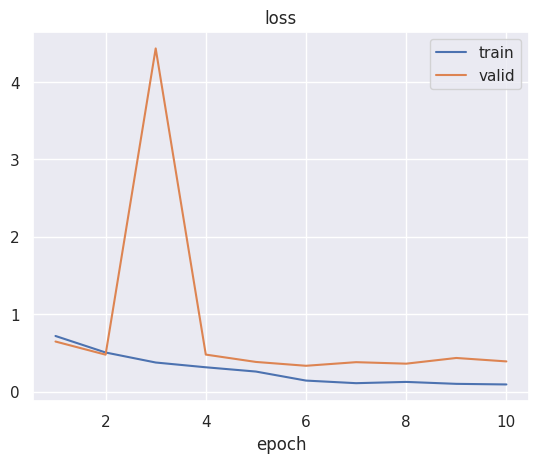

In [22]:
plt.plot(xticks, mem['train_loss'])
plt.plot(xticks, mem['valid_loss'])
plt.legend(['train', 'valid'])
plt.xlabel('epoch')
plt.title('loss')
plt.show()

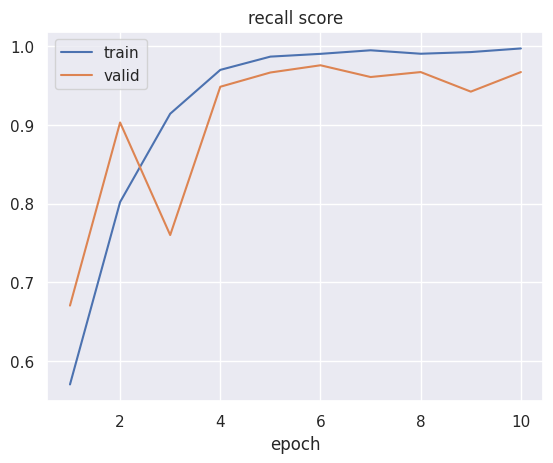

In [23]:
plt.plot(xticks, mem['train_recall_score'])
plt.plot(xticks, mem['valid_recall_score'])
plt.legend(['train', 'valid'])
plt.xlabel('epoch')
plt.title('recall score')
plt.show()

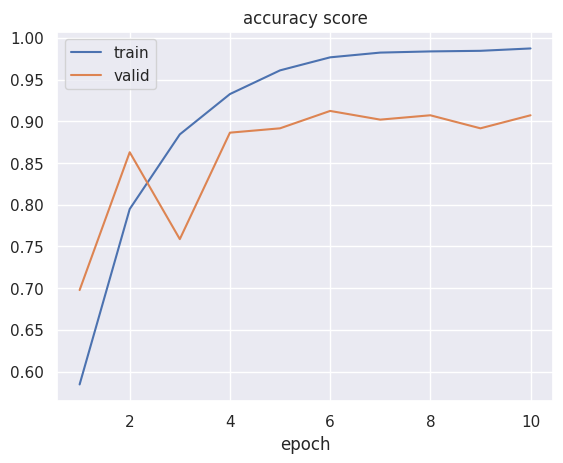

In [24]:
plt.plot(xticks, mem['train_accuracy_score'])
plt.plot(xticks, mem['valid_accuracy_score'])
plt.legend(['train', 'valid'])
plt.xlabel('epoch')
plt.title('accuracy score')
plt.show()

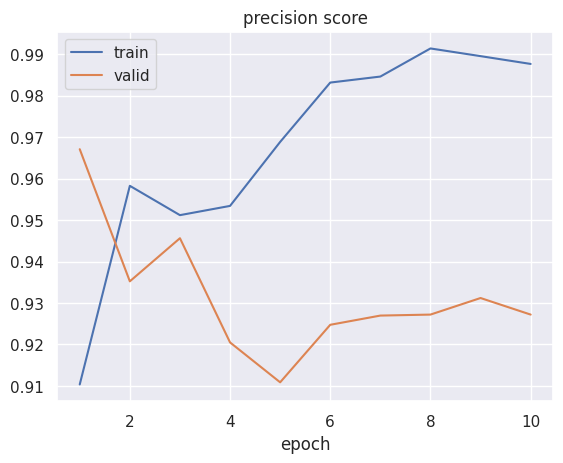

In [25]:
plt.plot(xticks, mem['train_precision_score'])
plt.plot(xticks, mem['valid_precision_score'])
plt.legend(['train', 'valid'])
plt.xlabel('epoch')
plt.title('precision score')
plt.show()

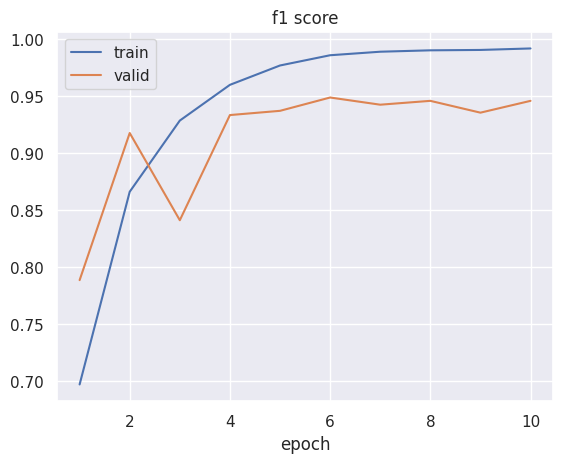

In [26]:
plt.plot(xticks, mem['train_f1_score'])
plt.plot(xticks, mem['valid_f1_score'])
plt.legend(['train', 'valid'])
plt.xlabel('epoch')
plt.title('f1 score')
plt.show()

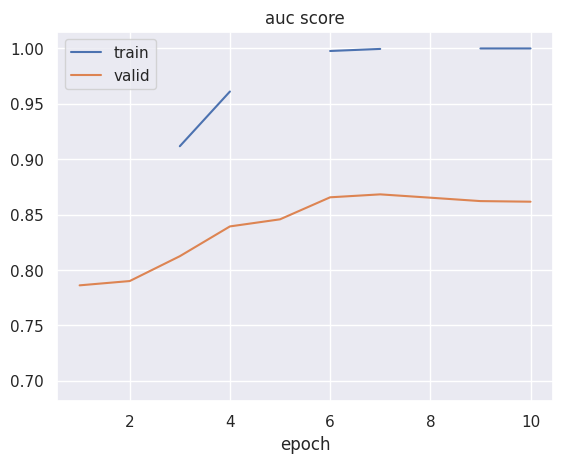

In [27]:
plt.plot(xticks, mem['train_auc'])
plt.plot(xticks, mem['valid_auc'])
plt.legend(['train', 'valid'])
plt.xlabel('epoch')
plt.title('auc score')
plt.show()